Calculating the gain using the peaks extracted from just the Polya model fitted to the integral histograms.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from math import floor, log10

In [2]:
#load the csvs with the peak information

spe_df = pd.read_csv('PMT7_spe_COMBINED_polya_peak_positions.csv')
darkrate_df = pd.read_csv('PMT7_DR_polya_peak_positions.csv')

#discard non-physical events
spe_df = spe_df[spe_df['polya_peak_pC'] > 0].reset_index(drop=True)
darkrate_df = darkrate_df[darkrate_df['polya_peak_pC'] > 0].reset_index(drop=True)

print('SPE')
print(spe_df)
print('DARKRATE')
print(darkrate_df)

SPE
   voltage  polya_peak_pC  polya_peak_error_pC
0     1750       1.893387             0.046198
1     1800       1.308456             0.014684
2     1850       1.449998             0.011952
3     1900       1.880817             0.012208
4     1950       2.573449             0.032855
5     2000       3.400162             0.024731
DARKRATE
    voltage  polya_peak_pC  polya_peak_error_pC
0      1750       1.490761             0.000622
1      1750       1.438780             0.000593
2      1750       1.442115             0.000586
3      1750       1.536344             0.000644
4      1750       1.473483             0.000608
5      1750       1.623898             0.000715
6      1800       1.245889             0.000084
7      1800       1.197377             0.000088
8      1800       1.209972             0.000087
9      1800       1.216644             0.000085
10     1800       1.228124             0.000086
11     1800       1.205578             0.000086
12     1850       1.388043        

In [3]:
#add gain columns to the data frames

def add_gain_columns(df):
    df=df.copy()
    df['gain'] = (df['polya_peak_pC']*(1e-12)/(1.6e-19))
    df['gain_error'] = (df['polya_peak_error_pC']*(1e-12)/(1.6e-19))
    return df

spe_df = add_gain_columns(spe_df)
darkrate_df = add_gain_columns(darkrate_df)

In [4]:
#find mean gain for each voltage in case of multiple trials

def average_gain_per_voltage(df):
    grouped = df.groupby('voltage')
    mean_gain = grouped['gain'].mean()
    mean_gain_err = grouped['gain_error'].apply(lambda errs: np.sqrt(np.sum(errs**2)) / len(errs)
    )
    
    out = pd.DataFrame({'voltage': mean_gain.index,
        'gain': mean_gain.values,
        'gain_error': mean_gain_err.values})
    
    return out.sort_values('voltage')

spe_avg_gain = average_gain_per_voltage(spe_df)
print(spe_avg_gain)
darkrate_avg_gain = average_gain_per_voltage(darkrate_df)
print(darkrate_avg_gain)

   voltage          gain     gain_error
0     1750  1.183367e+07  288735.580121
1     1800  8.177853e+06   91776.786742
2     1850  9.062488e+06   74699.378895
3     1900  1.175511e+07   76300.424011
4     1950  1.608406e+07  205343.794242
5     2000  2.125101e+07  154569.137678
   voltage          gain     gain_error
0     1750  9.380604e+06    1605.912496
1     1800  7.607900e+06     219.919804
2     1850  9.081650e+06     593.139191
3     1900  1.101687e+07    1145.281294
4     1950  1.564450e+07    2816.523448
5     2000  2.089373e+07  461565.725958


In [5]:
#gain model and fitting
def gain_model(V, A, B):
    return A * V**(14 * B)

def fit_gain_curve(voltage, gain, gain_err, ignore_voltage=1750):
    mask = np.ones_like(voltage, dtype=bool)

    if ignore_voltage is not None:
        mask &= voltage != ignore_voltage
    
    
    p0 = [5e-20, 0.7] #initial guesses
    bounds = (
        [1e-25, 0.2],   # lower bounds: A, B
        [1e-18, 0.9]    # upper bounds: A, B
    )
    popt, pcov = curve_fit(
        gain_model,
        voltage[mask],
        gain[mask],
        sigma=gain_err[mask],
        absolute_sigma=True,
        p0=p0,
        bounds=bounds,
        maxfev=10000
    )
    '''
    popt, pcov = curve_fit(
        gain_model,
        voltage,
        gain,
        sigma=gain_err,
        absolute_sigma=True,
        p0=p0,
        maxfev=10000
    )
    '''
    A_fit, B_fit = popt
    err_A, err_B = np.sqrt(np.diag(pcov))

    return A_fit, B_fit, err_A, err_B


A_spe, B_spe, errA_spe, errB_spe = fit_gain_curve(
    spe_avg_gain['voltage'].values,
    spe_avg_gain['gain'].values,
    spe_avg_gain['gain_error'].values
)

A_dark, B_dark, errA_dark, errB_dark = fit_gain_curve(
    darkrate_avg_gain['voltage'].values,
    darkrate_avg_gain['gain'].values,
    darkrate_avg_gain['gain_error'].values,
)


V_plot = np.linspace(
    min(spe_avg_gain['voltage'].min(), darkrate_avg_gain['voltage'].min()),max(spe_avg_gain['voltage'].max(), darkrate_avg_gain['voltage'].max()),300)


In [6]:
'''
# correct decimal places
def fmt_sig_figs(val, n=2):
    """Rounds a number to n significant figures and returns as a string."""
    if val == 0:
        return "0"
    # Calculate the order of magnitude
    mag = floor(log10(abs(val)))
    # Round to the appropriate decimal place
    rounded_val = round(val, -int(mag - (n - 1)))
    # Format as a float to avoid scientific notation in the string
    return f"{rounded_val:g}"

def format_scientific_latex(val, err, n=2):
    """
    Formats a value and error into LaTeX scientific notation 
    sharing the same power of 10.
    """
    if err <= 0:
        return f"{val:.1e} \pm {err:.1e}"

    # 1. Find the exponent of the value
    exponent = floor(log10(abs(val)))
    
    # 2. Scale both by that exponent
    factor = 10**exponent
    scaled_val = val / factor
    scaled_err = err / factor
    
    # 3. Return the LaTeX string
    # n controls decimal places (e.g., n=2 gives 1.23)
    return (f"({scaled_val:.{n}f} \pm {scaled_err:.{n}f}) "
            f"\\times 10^{{{exponent}}}")

# ---- Lights ON fit ----
if popt_on is not None:
    a_tex_on = format_scientific_latex(popt_on[0], perr_on[0], n=2)
    b_tex_on = format_scientific_latex(popt_on[1], perr_on[1], n=2)
    
    label_on = (
        r'Lights On fit: $A e^{BV}$' +
        f'\nA = ${a_tex_on}$' +
        f'\nB = ${b_tex_on}$'
    )
    if chi2nu_on is not None:
        label_on += f'\n$\chi^2_\\nu$ = {fmt_sig_figs(chi2nu_on, n=2)}'

# ---- Lights OFF fit ----
if popt_off is not None:
    a_tex_off = format_scientific_latex(popt_off[0], perr_off[0], n=2)
    b_tex_off = format_scientific_latex(popt_off[1], perr_off[1], n=2)
    
    label_off = (
        r'Lights Off fit: $A e^{BV}$' +
        f'\nA = ${a_tex_off}$' +
        f'\nB = ${b_tex_off}$'
    )
    if chi2nu_off is not None:
        label_off += f'\n$\chi^2_\\nu$ = {fmt_sig_figs(chi2nu_off, n=2)}'
'''

<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
/var/folders/54/shy8r4g15d33hf9px0m5hytc0000gn/T/ipykernel_61614/3051780092.py:20: SyntaxWarning: invalid escape sequence '\p'
  return f"{val:.1e} \pm {err:.1e}"


'\n# correct decimal places\ndef fmt_sig_figs(val, n=2):\n    """Rounds a number to n significant figures and returns as a string."""\n    if val == 0:\n        return "0"\n    # Calculate the order of magnitude\n    mag = floor(log10(abs(val)))\n    # Round to the appropriate decimal place\n    rounded_val = round(val, -int(mag - (n - 1)))\n    # Format as a float to avoid scientific notation in the string\n    return f"{rounded_val:g}"\n\ndef format_scientific_latex(val, err, n=2):\n    """\n    Formats a value and error into LaTeX scientific notation \n    sharing the same power of 10.\n    """\n    if err <= 0:\n        return f"{val:.1e} \\pm {err:.1e}"\n\n    # 1. Find the exponent of the value\n    exponent = floor(log10(abs(val)))\n\n    # 2. Scale both by that exponent\n    factor = 10**exponent\n    scaled_val = val / factor\n    scaled_err = err / factor\n\n    # 3. Return the LaTeX string\n    # n controls decimal places (e.g., n=2 gives 1.23)\n    return (f"({scaled_val:.{

In [7]:
#compute chi squareds

def chi_squared(y_data, y_model, y_err, n_params):
    chi2 = np.sum(((y_data-y_model)/y_err)**2)
    dof = len(y_data)-n_params
    chi2_reduced = chi2/dof
    return chi2, chi2_reduced


y_spe_model = gain_model(spe_avg_gain['voltage'].values, A_spe, B_spe)
chi2_spe, chi2_red_spe = chi_squared(
    spe_avg_gain['gain'].values,
    y_spe_model,
    spe_avg_gain['gain_error'].values,
    n_params=2
)


y_dark_model = gain_model(darkrate_avg_gain['voltage'].values,A_dark,B_dark)
chi2_dark, chi2_red_dark = chi_squared(
    darkrate_avg_gain['gain'].values,
    y_dark_model,
    darkrate_avg_gain['gain_error'].values,
    n_params=2
)

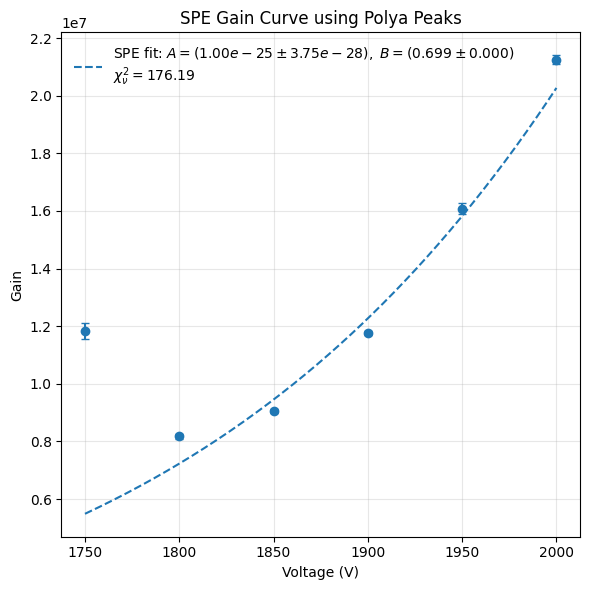

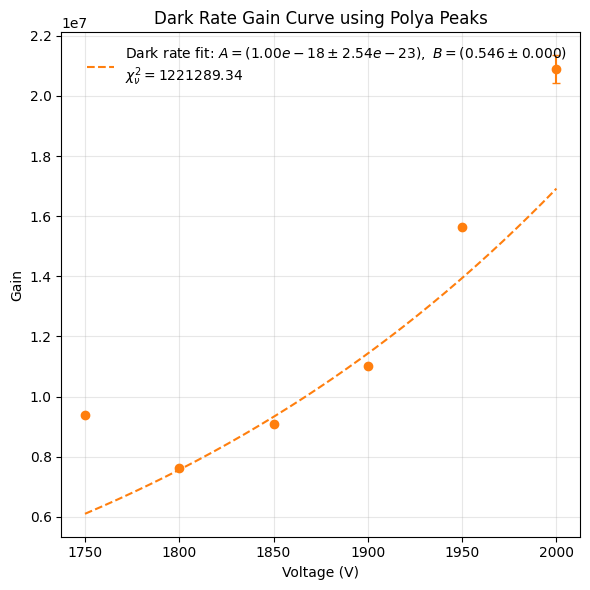

In [8]:
#plot gain curves and gain model = A V^14B separately
plt.figure(figsize=(6, 6))
plt.errorbar(spe_avg_gain['voltage'],spe_avg_gain['gain'],yerr=spe_avg_gain['gain_error'],fmt='o',color='tab:blue',capsize=3)
plt.plot(V_plot,gain_model(V_plot, A_spe, B_spe),'--',color='tab:blue',label=(
        rf'SPE fit: $A=({A_spe:.2e}\pm{errA_spe:.2e}),\ B=({B_spe:.3f}\pm{errB_spe:.3f})$'
        + f'\n$\\chi^2_\\nu={chi2_red_spe:.2f}$'
    ))
plt.xlabel('Voltage (V)')
plt.ylabel('Gain')
plt.title('SPE Gain Curve using Polya Peaks')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend(frameon=False)
plt.show()


plt.figure(figsize=(6, 6))
plt.errorbar(darkrate_avg_gain['voltage'],darkrate_avg_gain['gain'],yerr=darkrate_avg_gain['gain_error'],fmt='o',color='tab:orange', capsize=3)
plt.plot(V_plot,gain_model(V_plot, A_dark, B_dark),'--',color='tab:orange',label=(
        rf'Dark rate fit: $A=({A_dark:.2e}\pm{errA_dark:.2e}),\ B=({B_dark:.3f}\pm{errB_dark:.3f})$'
        + f'\n$\\chi^2_\\nu={chi2_red_dark:.2f}$'
    ))
plt.xlabel('Voltage (V)')
plt.ylabel('Gain')
plt.title('Dark Rate Gain Curve using Polya Peaks')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend(frameon=False)
plt.show()


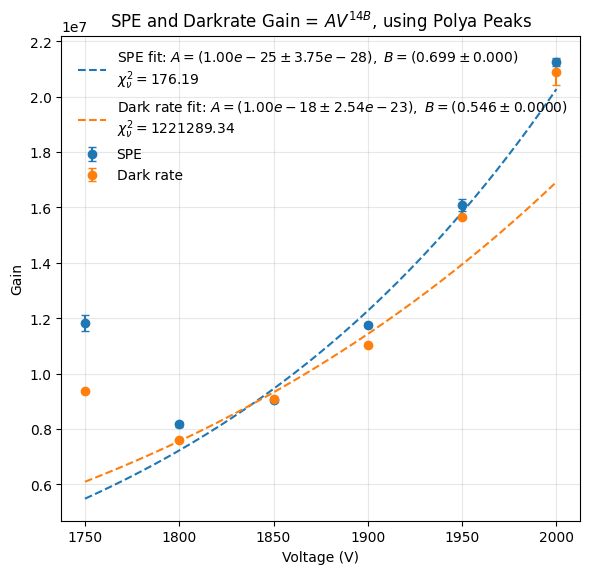

In [9]:
#plot gain curves and gain models = A V^14B together

plt.figure(figsize=(6, 6))
plt.errorbar(spe_avg_gain['voltage'],spe_avg_gain['gain'],yerr=spe_avg_gain['gain_error'],fmt='o',color='tab:blue',capsize=3,label='SPE')
plt.plot(V_plot,gain_model(V_plot, A_spe, B_spe),'--',color='tab:blue',label=(
    rf'SPE fit: '
    rf'$A = ({A_spe:.2e} \pm {errA_spe:.2e}),\ '
    rf'B = ({B_spe:.3f} \pm {errB_spe:.3f})$'
    + f'\n$\\chi^2_\\nu={chi2_red_spe:.2f}$'
))
plt.errorbar(darkrate_avg_gain['voltage'],darkrate_avg_gain['gain'],yerr=darkrate_avg_gain['gain_error'],fmt='o',color='tab:orange',capsize=3,label='Dark rate')
plt.plot(V_plot,gain_model(V_plot, A_dark, B_dark),'--',color='tab:orange',label=(
    rf'Dark rate fit: '
    rf'$A = ({A_dark:.2e} \pm {errA_dark:.2e}),\ '
    rf'B = ({B_dark:.3f} \pm {errB_dark:.4f})$'
    + f'\n$\\chi^2_\\nu={chi2_red_dark:.2f}$'
))
plt.xlabel('Voltage (V)')
plt.ylabel('Gain')
plt.legend(frameon=False)
plt.title(r'SPE and Darkrate Gain = $A V^{14B}$, using Polya Peaks')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
